# Cuaderno de Jupyter sobre parametros estelares con GAIA

<img src="https://cdn.sci.esa.int/documents/33580/35361/Gaia_MilkyWayWarp_625.gif" width=980>


- GAIA es una misión espacial con la tarea de catalogar y hacer un mapa en 3 dimensiones de la Vía Láctea.
- En el camino GAIA busca revelar la composición, formación y evolución de nuestra galaxia.
- Para mas información visitar: https://sci.esa.int/web/gaia

En este cuadernillo de Jupyter se tiene como objetivos:
* Poder acceder la base de datos de GAIA "Data Realese 3" (DR3) que contiene 1460 millones de objetos, con mediciones de las paralajes, movimientos propios, y fotometría.
* Aprender la manipulación de los datos usando el modulo de Python "<code>astropy</code>".
* Construir diagramas Hertzsprung-Russell (HR) con las observaciones e identificar los diferentes subgrupos de estrellas dentro del mismo.

## Llamando a las librerías base

In [1]:
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

# Librerías de astropy
import astropy.coordinates as coord
import astropy.units as u

# Librerías de astropy para leer tablas
# from astropy.table import QTable

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Accesando la base de datos.
- <code>astropy</code> cuenta con la función "<code>astroquery.gaia</code>" que facilita el acceso a los datos de GAIA

In [2]:
# Si el comando da error porque no esta instalado el paquete astroquery instalar usando pip
#pip install astroquery
from astroquery.gaia import Gaia

### Definiendo los parámetros de selección para los datos a solicitar

- El siguiente texto es para definir los parámetros que deseamos para hacer nuestra búsqueda de datos.
- El texto selecciona los primeros 4096 datos preguntando por los parámetros "ra", "dec", "parallax", "pmra", "pmdec", "radial_velocity", "phot_g_mean_mag", "phot_bp_mean_mag" y "phot_rp_mean_mag".
- La tabla a preguntar es el "Data Realese 3". GAIA cuenta con otras tablas que pueden ser seleccionadas.
- Al final la opción "parallax_over_error" selecciona los datos que el error no sea mayor al 10%, paralajes arriba de 4 $mas$ y donde la velocidad radial no sea nula.

In [3]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 4 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

- Es importante notar que el anterior comando no hace mas que definir todas las opciones en una sola variable llamada "query_text". Para hacer la solicitud de datos se debe ejecutar la solicitud con el comando "launch_job" y guardar los resultados con la función "get_results"


## Solicitando los datos

- El siguiente comando creara una tabla llamada "gaia_data". La tabla funciona y es muy parecida a las creadas con el modulo "pandas".


In [4]:
job = Gaia.launch_job(query_text)
gaia_data = job.get_results()

# Si desea guardar los datos en un archivo fisico descomente la siguiente linea.
#gaia_data.write('gaia_data.fits')

# Si desea leer la tabla desde un archivo descomente la siguiente linea.
# gaia_data = QTable.read('gaia_data.fits')

In [5]:
gaia_data

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
171.80987737943448,-12.086809574893953,7.191948381963115,80.77308417540777,31.038118561648464,0.0791312,13.987773,14.809981,12.990531
18.466531809347487,2.87878976386266,5.08382985708441,76.83054055120988,-11.105692960463237,24.974974,10.119948,10.387577,9.682716
104.92701163632249,63.24594185254482,5.881378619821566,-12.021013647907584,12.878513185859322,-19.423811,14.750455,15.776505,13.74654
329.22119244522736,56.63317207594698,4.8666916640832625,-28.08330414258523,2.514321404968325,-103.996155,14.473897,15.290248,13.5195055
129.9709255450639,27.631570971904303,7.513264990316233,-4.753118771321455,-7.496507650347014,-56.61028,10.025202,10.364753,9.515762
132.10459270933268,2.271051596123523,12.599344304105063,4.013977357436915,66.10200703095197,35.98448,11.123108,11.694805,10.408632
88.83105887052048,13.548943405272674,8.529614872196044,30.145566649225604,-41.55845921307802,79.80503,14.496056,15.714214,13.398944
77.0356559609996,-76.38573602851461,4.032150917693865,-35.29836308677816,-16.338243335376237,40.058613,13.268149,13.825207,12.559783


## Usando los datos de GAIA para construir un diagrama de Hertzsprung-Russell

- Usando la fotométrica se puede crear un diagrama Hertzsprung-Russell de GAIA como en la imagen a continuación:

<img src="https://cdn.sci.esa.int/documents/33580/35361/1567214809100-ESA_Gaia_DR2_HRD_Gaia_625.jpg">

- Para eso primero haremos algunos pasos intermedios 

### Cambiando las paralajes a distancias en parsecs

- Usando la función <code>Distance</code> es fácil cambiar las paralajes de la base de datos a distancias en parsecs.

In [6]:
dist0 = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))

### Calculando el "color"
- GAIA cuenta con tres filtros de color: azul, verde y rojo (BP, G, RP)

<img src="https://www.cosmos.esa.int/documents/29201/1645651/GaiaDR2Passbands.png/ba8d3078-0e7a-b316-92d9-cdce748e6484?t=1521129245183">

- Las magnitudes de las estrellas están en la tabla de datos bajo los nombres: ,<code>'phot_bp_mean_mag'</code>, <code>'phot_g_mean_mag'</code>, <code>'phot_rp_mean_mag'</code>

- De esta manera podemos llamar a los datos en el filtro y calcular el color BP-RP

In [7]:
BP = gaia_data['phot_bp_mean_mag']
RP = gaia_data['phot_rp_mean_mag']
Color = BP - RP

### Calculando la magnitud absoluta

- Lo bueno de los datos de GAIA es que tenemos la distancia medida de manera directa usando la paralaje.
- Esto quiere decir que podemos usar esa distancia para calcular las magnitudes absolutas $M$ para una banda o filtro dado.
- Esto se hace con la ecuación:

$$ m - M = 5 \log{\left(\dfrac{distancia}{10pc}\right)} $$

- Despejando para la magnitud ($m$) y usando las distancias calculadas arriba podemos despejar para $M$
- Pero para ahorrar tiempo y usar el potencial del modulo <code>astropy</code> usaremos la función <code>distmod</code>.
- De esta manera calcularemos $M$ usando simplemente:

$$ M = m - distmod $$

In [8]:
# calculando el modulo de la distancia
dist_mod = dist0.distmod

# obtenemos de los datos la magnitud aparente del filtro verde (G)
m = gaia_data['phot_g_mean_mag']

# Calculamos la magnitud absoluta
M = m - dist_mod

### Haciendo el diagrama Hertzsprung-Russell

- Con todo esto ya podemos hacer nuestro gráfico $M$ vs. Color, que básicamente es un diagrama Hertzsprung-Russell.

**Nota: No olvide invertir los ejes de $M$ ya que la magnitud es una cantidad que crece
 en luminosidad en cuanto mas baja es la magnitud.**

<IPython.core.display.Javascript object>


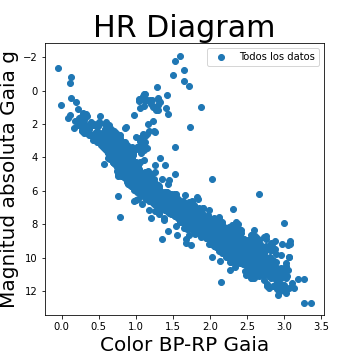

In [27]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(Color, M, 'o', label='Todos los datos')
plt.gca().invert_yaxis()

ax.set_xlabel("Color BP-RP Gaia",size=20)
ax.set_ylabel("Magnitud absoluta Gaia g",size=20)
ax.set_title("HR Diagram", size=30)
ax.legend()

## Manipulando las tablas con <code>pandas</code>
- La tabla puede ser manipulada para obtener subgrupos de datos que faciliten el análisis de un grupo mas pequeño de los datos.
- Por ejemplo: Si se quiere los datos para paralajes por encima de 7 $mas$ y debajo de 8 $mas$ el comando seria

>gaia_data[(gaia_data['parallax'] > 4 * u.mas) & (gaia_data['parallax'] < 7 * u.mas)]

- Se pueden agregar cuantos criterios de selección se deseen usando paréntesis y el condicional "&"
- Cabe destacar que la tabla "gaia_data" tiene unidades y si se desea hacer una selección se deben proporcionar las unidades usando el modulo "units" de astropy.

In [10]:
gd = gaia_data[(gaia_data['parallax'] > 4 ) & (gaia_data['parallax'] < 7 ) & (gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']> 0.3 ) & (gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag'] < 0.9 )]
gd

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
18.466531809347487,2.87878976386266,5.08382985708441,76.83054055120988,-11.105692960463237,24.974974,10.119948,10.387577,9.682716
259.491411358678,-58.84527725444102,4.358498689321255,1.8112838824563045,-11.303204850767912,-10.520577,10.321192,10.618219,9.8541765
189.97129110768293,-46.53502683259855,4.986917626297486,-20.550405451411322,-7.853634072046482,-0.3207542,9.9208555,10.168897,9.508286
127.00875981350795,-60.46078681536207,4.529610255458263,-8.894136721052865,11.780505527402669,7.5632067,10.758576,11.042034,10.315567
89.08891529461751,-23.375564356338113,6.174716638660832,-8.946122922229451,-30.243138720876235,20.539616,9.528021,9.803101,9.085469
89.75122195274709,71.33384612083127,6.786864259555966,4.111420622304124,-35.19984315557679,-1.0215006,8.923034,9.108255,8.59304
353.77902532666457,-23.905813522661074,6.371479243100046,24.216940403135407,16.5238263260635,21.971739,10.370821,10.665616,9.912976
22.543293171697613,0.24357941511309059,6.3582217107666565,-18.32082140765348,-7.165961649411648,13.190889,11.042707,11.380926,10.538818


### Haciendo un DHR para el subgrupo
- Calculemos los mismos parametros que para la tabla <code>gaia_data</code>

In [11]:
dist_gd = coord.Distance(parallax=u.Quantity(gd['parallax']))

BP_gd = gd['phot_bp_mean_mag']
RP_gd = gd['phot_rp_mean_mag']
Color_gd = BP_gd - RP_gd

# calculando el modulo de la distancia
dist_mod_gd = dist_gd.distmod

# obtenemos de los datos la magnitud aparente del filtro verde (G)
m_gd = gd['phot_g_mean_mag']

# Calculamos la magnitud absoluta
M_gd = m_gd - dist_mod_gd

<IPython.core.display.Javascript object>


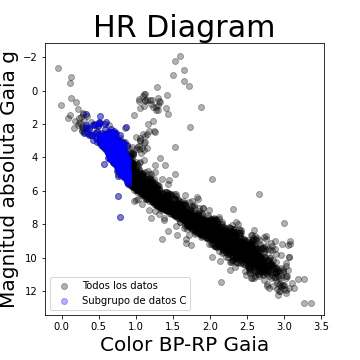

In [28]:
#plotting the HR Diagram
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(Color, M, 'o', c='k', label='Todos los datos', alpha=0.3)
ax.plot(Color_gd, M_gd, 'o', c='b', label='Subgrupo de datos C', alpha=0.3)

plt.gca().invert_yaxis()

ax.set_xlabel("Color BP-RP Gaia",size=20)
ax.set_ylabel("Magnitud absoluta Gaia g",size=20)
ax.set_title("HR Diagram", size=30)
ax.legend()

## Problema 1:
- Si quisiera medir la distancia de una estrella cercana al centro galáctico (8.3 kpc) ¿Cuánto debería ser la resolución angular mínima de GAIA para medir la paralaje de dicha estrella?
- La mas alta resolución que GAIA puede alcanzar ese de 24$\mu as$ ¿Puede Gaia medir la distancia de una estrella en el centro de la Galaxia?

## Problema 2:

- Haga una selección de las primera 20000 estrellas con paralajes mayores que 3 mas.
- Cree una tabla de datos de pandas (DataFrame)
- Con los datos haga un diagrama HR.
- Usando los criterios de selección cree tres sub-grupos que representen:
    - La secuencia principal
    - El brazo de las gigantes rojas
    - Las enanas blancas
- Haga un nuevo diagrama HR donde se muestren los nuevos subgrupos en colores para dist
inguirlos.

## Solución problema 1:

- Si quisiera medir la distancia de una estrella cercana al centro galáctico (8.3 kpc) ¿Cuánto debería ser la resolución angular mínima de GAIA para medir la paralaje de dicha estrella?

Usaremos la siguiente formula que sacamos del Carrol: 

$$ D = \dfrac{1}{p''}pc $$ 
Podemos encontrar la resolución que deberia de tener el GAIA

In [13]:
D = (8.3*u.kpc).to(u.pc)

In [14]:
parallax = (((1*u.pc)/(D))*u.arcsec).to(u.mas)
parallax

<Quantity 0.12048193 mas>

- La mas alta resolución que GAIA puede alcanzar ese de 24$\mu as$ ¿Puede Gaia medir la distancia de una estrella en el centro de la Galaxia?

Usaremos la misma formula anterior:

In [15]:
parallax_2 = (24*u.microarcsecond).to(u.mas)
parallax_2

<Quantity 0.024 mas>

Si hacemos la comparación entre las resoluciones que tenemos:

In [16]:
parallax_2/parallax

<Quantity 0.1992>

Tambien podemos calcular la distancia con esta resolución usando la formula anterior:

In [34]:
D_max = ((1*u.arcsecond)/(parallax_2.to(u.arcsecond)))*u.pc
D_max.to(u.kpc)

<Quantity 41.66666667 kpc>

Sabemos que el diámetro de la galaxia es de aprox. unos 30kpc y el centro de esta se encuentra a 8.2kpc respecto a nosotros, por tanto, con la distancia máxima calculada el Gaia podría medir la distancia de una estrella en el centro de la galaxia.

## Solución problema 2:

- Haga una selección de las primera 20000 estrellas con paralajes mayores que 3 mas.

In [17]:
query_text = '''SELECT TOP 20000 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 3 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

- Cree una tabla de datos de pandas (DataFrame)

In [18]:
new_job = Gaia.launch_job(query_text)
gaia_data2 = new_job.get_results()
gaia_data2

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
171.80987737943448,-12.086809574893953,7.191948381963115,80.77308417540777,31.038118561648464,0.0791312,13.987773,14.809981,12.990531
18.466531809347487,2.87878976386266,5.08382985708441,76.83054055120988,-11.105692960463237,24.974974,10.119948,10.387577,9.682716
104.92701163632249,63.24594185254482,5.881378619821566,-12.021013647907584,12.878513185859322,-19.423811,14.750455,15.776505,13.74654
329.22119244522736,56.63317207594698,4.8666916640832625,-28.08330414258523,2.514321404968325,-103.996155,14.473897,15.290248,13.5195055
129.9709255450639,27.631570971904303,7.513264990316233,-4.753118771321455,-7.496507650347014,-56.61028,10.025202,10.364753,9.515762
272.956607756348,-62.71649705591161,3.3441315031249057,-0.6464535073043114,-16.756894757989265,9.606025,13.348048,13.966247,12.59781
132.10459270933268,2.271051596123523,12.599344304105063,4.013977357436915,66.10200703095197,35.98448,11.123108,11.694805,10.408632
88.83105887052048,13.548943405272674,8.529614872196044,30.145566649225604,-41.55845921307802,79.80503,14.496056,15.714214,13.398944


- Con los datos haga un diagrama HR.

In [19]:
dist_2 = coord.Distance(parallax=u.Quantity(gaia_data2['parallax']))

In [20]:
BP_2 = gaia_data2['phot_bp_mean_mag']
RP_2 = gaia_data2['phot_rp_mean_mag']
Color_2 = BP_2 - RP_2

In [21]:
# calculando el modulo de la distancia
dist_mod_2 = dist_2.distmod

# obtenemos de los datos la magnitud aparente del filtro verde (G)
m_2 = gaia_data2['phot_g_mean_mag']

# Calculamos la magnitud absoluta
M_2 = m_2 - dist_mod_2

<IPython.core.display.Javascript object>


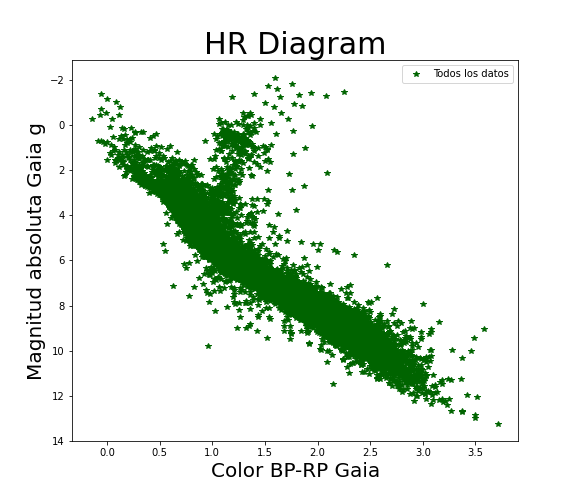

In [29]:
fig, ax = plt.subplots(figsize=(8,7))

ax.plot(Color_2, M_2, '*', label='Todos los datos', c = 'darkgreen')
plt.gca().invert_yaxis()

ax.set_xlabel("Color BP-RP Gaia",size=20)
ax.set_ylabel("Magnitud absoluta Gaia g",size=20)
ax.set_title("HR Diagram", size=30)
ax.legend()

- Usando los criterios de selección cree tres sub-grupos que representen:
    - La secuencia principal
    - El brazo de las gigantes rojas
    - Las enanas blancas

#### Secuencia principal

In [23]:
pri= gaia_data2[(gaia_data2['parallax'] > 4) & (gaia_data2['parallax'] < 13) & (gaia_data2['phot_bp_mean_mag'] - gaia_data2['phot_rp_mean_mag']> 0 ) & (gaia_data2['phot_bp_mean_mag'] - gaia_data2['phot_rp_mean_mag'] < 3.5) & (M_2>1) & (M_2<12)]
pri

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
171.80987737943448,-12.086809574893953,7.191948381963115,80.77308417540777,31.038118561648464,0.0791312,13.987773,14.809981,12.990531
18.466531809347487,2.87878976386266,5.08382985708441,76.83054055120988,-11.105692960463237,24.974974,10.119948,10.387577,9.682716
104.92701163632249,63.24594185254482,5.881378619821566,-12.021013647907584,12.878513185859322,-19.423811,14.750455,15.776505,13.74654
329.22119244522736,56.63317207594698,4.8666916640832625,-28.08330414258523,2.514321404968325,-103.996155,14.473897,15.290248,13.5195055
129.9709255450639,27.631570971904303,7.513264990316233,-4.753118771321455,-7.496507650347014,-56.61028,10.025202,10.364753,9.515762
132.10459270933268,2.271051596123523,12.599344304105063,4.013977357436915,66.10200703095197,35.98448,11.123108,11.694805,10.408632
88.83105887052048,13.548943405272674,8.529614872196044,30.145566649225604,-41.55845921307802,79.80503,14.496056,15.714214,13.398944
77.0356559609996,-76.38573602851461,4.032150917693865,-35.29836308677816,-16.338243335376237,40.058613,13.268149,13.825207,12.559783


In [24]:
dist_pri = coord.Distance(parallax=u.Quantity(pri['parallax']))

BP_pri = pri['phot_bp_mean_mag']
RP_pri = pri['phot_rp_mean_mag']
Color_pri = BP_pri - RP_pri

# calculando el modulo de la distancia
dist_mod_pri = dist_pri.distmod

# obtenemos de los datos la magnitud aparente del filtro verde (G)
m_pri = pri['phot_g_mean_mag']

# Calculamos la magnitud absoluta
M_pri = m_pri - dist_mod_pri

#### El brazo de las gigantes rojas

In [25]:
red_stars = gaia_data2[(gaia_data2['parallax'] > 4) & (gaia_data2['parallax'] < 13) & (gaia_data2['phot_bp_mean_mag'] - gaia_data2['phot_rp_mean_mag']> 0.89 ) & (gaia_data2['phot_bp_mean_mag'] - gaia_data2['phot_rp_mean_mag'] < 2.3) & (M_2>-2) & (M_2<2)]
red_stars

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32,float32
37.93089459029714,19.29079672106284,5.567776813866466,13.405462665936495,-26.55216668900193,-0.74409294,8.103913,8.635762,7.4090037
330.3870919481059,-15.61204705231511,7.0114632292318735,38.099298923359655,-5.692886861074424,6.413607,6.828051,7.2733736,6.21306
102.99975006953139,23.601682615516822,7.274806414892579,-39.65115878770199,-8.859152668707132,33.03494,5.1445856,5.93206,4.282966
100.77759965707243,3.033758398521551,4.544017263676118,9.241123771182949,-9.491685614720163,30.203808,5.7528563,6.4483852,4.9490967
255.59402912487428,-10.952058734018877,7.041889840884061,-30.328761429433126,19.07005773304722,-29.721859,6.760123,7.686559,5.8045506
284.1797636827613,-24.62079004696839,4.977574327430089,7.0106268834831225,-13.764247806354469,-9.249194,7.1755896,7.767666,6.439968
269.321737105814,-71.09480505470259,4.994211873115494,-33.180541530119605,-113.24894402082249,-21.15663,6.7921114,7.4370794,6.019627
266.0234978516663,-38.80593640567238,5.583768166360413,-13.372223505148725,-43.39293949696912,-72.348595,6.4771724,6.9593463,5.830635


In [30]:
dist_red = coord.Distance(parallax=u.Quantity(red_stars['parallax']))

BP_red = red_stars['phot_bp_mean_mag']
RP_red = red_stars['phot_rp_mean_mag']
Color_red = BP_red - RP_red

# calculando el modulo de la distancia
dist_mod_red = dist_red.distmod

# obtenemos de los datos la magnitud aparente del filtro verde (G)
m_red = red_stars['phot_g_mean_mag']

# Calculamos la magnitud absoluta
M_red = m_red - dist_mod_red

#### Enanas blancas

No tenemos suficientes datos para graficarlas.

- Haga un nuevo diagrama HR donde se muestren los nuevos subgrupos en colores para distinguirlos.

<IPython.core.display.Javascript object>


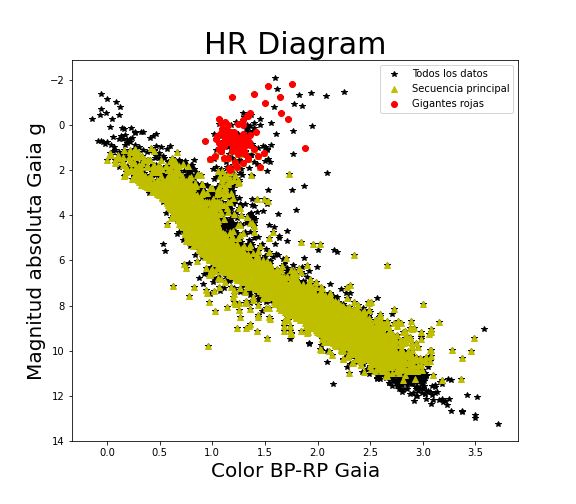

In [31]:
fig, ax = plt.subplots(figsize=(8,7))

ax.plot(Color_2, M_2, '*', label='Todos los datos', c = 'k')
ax.plot(Color_pri, M_pri, '^', label='Secuencia principal', c='y')
ax.plot(Color_red, M_red, 'o', label='Gigantes rojas', c='r')

plt.gca().invert_yaxis()

ax.set_xlabel("Color BP-RP Gaia",size=20)
ax.set_ylabel("Magnitud absoluta Gaia g",size=20)
ax.set_title("HR Diagram", size=30)
ax.legend()